In [97]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interact_manual


First, we will import and sanitize our datasets, starting with the COVID data from Johns Hopkins.


In [98]:
dfCOVID = pd.read_csv('johnshopkins.csv')
dfCOVID.head()


,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,3233,3258,3300,3329,3426,3510,3570,3647,3698,3741
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,10489,10665,10806,10898,11061,11212,11364,11556,11722,11827
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,1264,1269,1272,1275,1292,1296,1309,1318,1330,1336
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,1398,1417,1441,1455,1504,1520,1548,1577,1601,1613
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,3663,3744,3776,3803,3881,3950,4036,4118,4191,4218


The imported COVID dataset has several columns that are not useful for the scope of this project. Let's drop those.

In [99]:
to_drop = ['iso2',
           'iso3',
           'code3',
           'FIPS',
           'Country_Region',
           'Admin2',
           'Province_State',
           'Combined_Key',
           'Lat',
           'Long_']

dfCOVID.drop(to_drop, inplace=True, axis=1)

dfCOVID.head()

,UID,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20
0,84001001,0,0,0,0,0,0,0,0,0,...,3233,3258,3300,3329,3426,3510,3570,3647,3698,3741
1,84001003,0,0,0,0,0,0,0,0,0,...,10489,10665,10806,10898,11061,11212,11364,11556,11722,11827
2,84001005,0,0,0,0,0,0,0,0,0,...,1264,1269,1272,1275,1292,1296,1309,1318,1330,1336
3,84001007,0,0,0,0,0,0,0,0,0,...,1398,1417,1441,1455,1504,1520,1548,1577,1601,1613
4,84001009,0,0,0,0,0,0,0,0,0,...,3663,3744,3776,3803,3881,3950,4036,4118,4191,4218


The Johns Hopkins team has already assigned a unique identifier to each county - let's make sure we have it set
as the index for our dataframe.

In [100]:
dfCOVID = dfCOVID.set_index('UID')
dfCOVID.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20
UID,,,,,,,,,,,,,,,,,,,,,
84001001,0,0,0,0,0,0,0,0,0,0,...,3233,3258,3300,3329,3426,3510,3570,3647,3698,3741
84001003,0,0,0,0,0,0,0,0,0,0,...,10489,10665,10806,10898,11061,11212,11364,11556,11722,11827
84001005,0,0,0,0,0,0,0,0,0,0,...,1264,1269,1272,1275,1292,1296,1309,1318,1330,1336
84001007,0,0,0,0,0,0,0,0,0,0,...,1398,1417,1441,1455,1504,1520,1548,1577,1601,1613
84001009,0,0,0,0,0,0,0,0,0,0,...,3663,3744,3776,3803,3881,3950,4036,4118,4191,4218


Next, let's make sure our columns' datatypes are set up appropriately. We'll leave the string columns as they are,
but we'll need to make sure each of the case count columns is stored numerically.



In [101]:
print (dfCOVID.filter(like='1'))
for col in dfCOVID.filter(like='1').columns:
    dfCOVID[col] = pd.to_numeric(dfCOVID[col], errors='coerce')

dfCOVID.head()


          1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
UID                                                                       
84001001        0        0        0        0        0        0        0   
84001003        0        0        0        0        0        0        0   
84001005        0        0        0        0        0        0        0   
84001007        0        0        0        0        0        0        0   
84001009        0        0        0        0        0        0        0   
...           ...      ...      ...      ...      ...      ...      ...   
84056039        0        0        0        0        0        0        0   
84056041        0        0        0        0        0        0        0   
84090056        0        0        0        0        0        0        0   
84056043        0        0        0        0        0        0        0   
84056045        0        0        0        0        0        0        0   

          1/29/20  1/30/

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,12/11/20,12/12/20,12/13/20,12/14/20,12/15/20,12/16/20,12/17/20,12/18/20,12/19/20,12/20/20
UID,,,,,,,,,,,,,,,,,,,,,
84001001,0,0,0,0,0,0,0,0,0,0,...,3233,3258,3300,3329,3426,3510,3570,3647,3698,3741
84001003,0,0,0,0,0,0,0,0,0,0,...,10489,10665,10806,10898,11061,11212,11364,11556,11722,11827
84001005,0,0,0,0,0,0,0,0,0,0,...,1264,1269,1272,1275,1292,1296,1309,1318,1330,1336
84001007,0,0,0,0,0,0,0,0,0,0,...,1398,1417,1441,1455,1504,1520,1548,1577,1601,1613
84001009,0,0,0,0,0,0,0,0,0,0,...,3663,3744,3776,3803,3881,3950,4036,4118,4191,4218


Next, create a new dataframe indicating the daily total case count. This will give
us a more lightweight dataframe to work with for our analysis.

In [102]:
dfCOVIDtotal = pd.DataFrame(dfCOVID.sum(),
                            columns = ['Cases'])
dfCOVIDtotal.index = pd.to_datetime(dfCOVIDtotal.index)
print(dfCOVIDtotal.index.dtype)
dfCOVIDtotal.head()

datetime64[ns]


,Cases
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,2
2020-01-26,5


That should do it for the COVID set - their data is managed by a highly qualified team, so let's avoid skewing the data
by unnecessarily altering it. Next is the client's staffing data!

In [103]:
dfN7 = pd.read_csv('N7data.csv')
dfN7.head()

,employeeID,clientCompany,clientIndustry,startDate,endDate,jobTitle,payrate,markup,billrate,hours
0,1776,Corwin LLC,NaN,10/18/2020,10/18/2020,Account Executive,13.03,39,18.11,1.199923
1,1253,"Breitenberg, Rogahn and Abbott",Real Estate,4/7/2020,4/7/2020,Research Associate,23.28,34,31.20,1.381912
2,1865,Jast Group,NaN,11/18/2020,11/18/2020,Dental Hygienist,10.54,29,13.60,1.452889
3,1065,Mann-Kihn,Major Banks,1/24/2020,1/24/2020,Executive Secretary,16.46,36,22.39,1.674138
4,1880,Conroy-Beer,Major Chemicals,11/25/2020,11/25/2020,Geologist II,12.29,22,14.99,2.265136


Let's drop the columns we don't need and set employeeID as our index.


In [104]:
to_drop = ['clientCompany',
           'clientIndustry',
           'jobTitle']

dfN7.drop(to_drop, inplace=True, axis=1)
dfN7 = dfN7.set_index('employeeID')
dfN7.head()

,startDate,endDate,payrate,markup,billrate,hours
employeeID,,,,,,
1776,10/18/2020,10/18/2020,13.03,39,18.11,1.199923
1253,4/7/2020,4/7/2020,23.28,34,31.20,1.381912
1865,11/18/2020,11/18/2020,10.54,29,13.60,1.452889
1065,1/24/2020,1/24/2020,16.46,36,22.39,1.674138
1880,11/25/2020,11/25/2020,12.29,22,14.99,2.265136


Just like our COVID set, we'll make sure numerical data is stored as an appropriate datatype.

In [105]:
dfN7['startDate'] = pd.to_datetime(dfN7['startDate'], format='%m/%d/%Y')
dfN7['endDate'] = pd.to_datetime(dfN7['endDate'], format='%m/%d/%Y')
dfN7['payrate'] = pd.to_numeric(dfN7['payrate'])
dfN7['markup'] = pd.to_numeric(dfN7['markup'])
dfN7['billrate'] = pd.to_numeric(dfN7['billrate'])
dfN7['hours'] = pd.to_numeric(dfN7['hours'])
dfN7.head()

,startDate,endDate,payrate,markup,billrate,hours
employeeID,,,,,,
1776,2020-10-18,2020-10-18,13.03,39,18.11,1.199923
1253,2020-04-07,2020-04-07,23.28,34,31.20,1.381912
1865,2020-11-18,2020-11-18,10.54,29,13.60,1.452889
1065,2020-01-24,2020-01-24,16.46,36,22.39,1.674138
1880,2020-11-25,2020-11-25,12.29,22,14.99,2.265136


In [106]:
def find_cases_in_date_range(start_date, end_date):
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    dfCasesInDateRange = dfCOVIDtotal.loc[(dfCOVIDtotal.index >= start_date) & (dfCOVIDtotal.index <= end_date)].copy()
    total_cases = dfCasesInDateRange['Cases'].sum()
    print(f'There were {total_cases} COVID cases between {start_date.date()} and {end_date.date()}.')
    return dfCasesInDateRange

_ = interact(find_cases_in_date_range,
             start_date=widgets.DatePicker(value=pd.to_datetime('2020-01-01'), description="Start Date", disabled=False),
             end_date=widgets.DatePicker(value=pd.to_datetime('2020-12-25'), description="End Date", disabled=False))

interactive(children=(DatePicker(value=Timestamp('2020-01-01 00:00:00'), description='Start Date'), DatePicker…

In [107]:
def find_placements_in_date_range(start_date, end_date):
    start_date = pd.Timestamp(start_date)
    end_date = pd.Timestamp(end_date)
    dfPlacementsInDateRange = dfN7.loc[(dfN7.startDate >= start_date) & (dfN7.endDate <= end_date)].copy()
    total_placements = dfPlacementsInDateRange.count()
    print(f'There were {total_placements.startDate} placements active between {start_date.date()} and {end_date.date()}.')
    return dfPlacementsInDateRange

_ = interact(find_placements_in_date_range,
             start_date=widgets.DatePicker(value=pd.to_datetime('2020-01-01'), description="Start Date", disabled=False),
             end_date=widgets.DatePicker(value=pd.to_datetime('2020-12-25'), description="End Date", disabled=False))


interactive(children=(DatePicker(value=Timestamp('2020-01-01 00:00:00'), description='Start Date'), DatePicker…

In [108]:
def find_placements_active_on_date(date_input):
    date = pd.Timestamp(date_input)
    dfActivePlacementsByDate = dfN7.loc[(dfN7.startDate <= date) & (dfN7.endDate >= date)].copy()
    date_placements = dfActivePlacementsByDate.count()
    return date_placements.startDate

In [116]:
dfCOVIDtotal['Active Placements'] = [find_placements_active_on_date(x) for x in dfCOVIDtotal.index]
dfCOVIDtotal.head()


,Cases,Active Placements
2020-01-22,1,57
2020-01-23,1,60
2020-01-24,2,61
2020-01-25,2,63
2020-01-26,5,69


[[2.23460796e+06 1.49973333e+02]
 [8.05979041e+06 1.52265306e+02]
 [1.59114026e+07 1.53947368e+02]
 [5.47673808e+06 1.51278689e+02]
 [2.62861840e+05 1.26830189e+02]
 [1.18797310e+07 1.53250000e+02]]


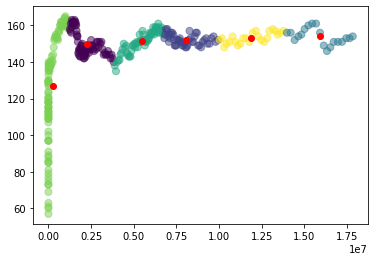

In [118]:
kmeans = KMeans (n_clusters=6).fit(dfCOVIDtotal)
centroids = kmeans.cluster_centers_

plt.scatter(dfCOVIDtotal['Cases'], dfCOVIDtotal['Active Placements'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red')
plt.show()

In [ ]:
print(dfCOVIDtotal)
